## - Download Pytorch BERT

In [1]:
!pip install pytorch_pretrained_bert

## - Import

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import random as rnfv
import pandas as pd

from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torch.nn.utils.rnn import pad_sequence
from torch_snippets import *
from torchmetrics import ConfusionMatrix, F1Score

from pytorch_pretrained_bert import BertModel
from pytorch_pretrained_bert import BertTokenizer

2022-07-26 04:10:10.035349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-26 04:10:10.035370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## - Parameters

In [3]:
# Data
train_data_path = './data/trac-1/english/agr_en_train.csv' # Path of data
valid_data_path = './data/trac-1/english/agr_en_dev.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

batch_size = 8  # Batch size

# Preprocessing
word_max_len = 64

# Model
h1 = 768
h2 = 128
drop_out_rate = 0.2

# Training
epochs = 20  # Train epochs
learning_rate = 3e-6

Train data path: ./data/trac-1/english/agr_en_train.csv
Valid data path: ./data/trac-1/english/agr_en_dev.csv


## - Load Aggression Identification Dataset

In [4]:
# Train
train_df = pd.read_csv(train_data_path, names = ['SOURCE', 'TEXT', 'AGGRESSION_CLASS'], 
                   usecols=['TEXT', 'AGGRESSION_CLASS'])
print('Column of df:', list(train_df))
print('Size of data:', len(train_df))
train_df.head()

Column of df: ['TEXT', 'AGGRESSION_CLASS']
Size of data: 12000


,TEXT,AGGRESSION_CLASS
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG


In [5]:
valid_df = pd.read_csv(valid_data_path, names = ['SOURCE', 'TEXT', 'AGGRESSION_CLASS'], 
                   usecols=['TEXT', 'AGGRESSION_CLASS'])
print('Column of df:', list(valid_df))
print('Size of data:', len(valid_df))
valid_df.head()

Column of df: ['TEXT', 'AGGRESSION_CLASS']
Size of data: 3001


,TEXT,AGGRESSION_CLASS
0,The quality of re made now makes me think it i...,CAG
1,@siva \nHow is ur mother???\nHow is ur wife???...,NAG
2,Also see ....hw ur RSS activist caught in Burk...,NAG
3,On the death of 2 jawans in LOC CROSS FIRING\n...,NAG
4,Modi ho ya Manmohan singh saala yeh log kuch n...,OAG


## - Data Preprocessing

In [6]:
# Shuffle data
np.random.seed(41)
train_shuffled = train_df.reindex(np.random.permutation(train_df.index))
valid_shuffled = valid_df.reindex(np.random.permutation(valid_df.index))

In [7]:
# Train
CAG = train_shuffled[train_shuffled['AGGRESSION_CLASS'] == 'CAG']
OAG = train_shuffled[train_shuffled['AGGRESSION_CLASS'] == 'OAG']
NAG = train_shuffled[train_shuffled['AGGRESSION_CLASS'] == 'NAG']

concated_train = pd.concat([CAG, OAG, NAG], ignore_index=True)
concated_train['LABEL'] = 0

# Class to idx
concated_train.loc[concated_train['AGGRESSION_CLASS'] == 'CAG', 'LABEL'] = 0
concated_train.loc[concated_train['AGGRESSION_CLASS'] == 'OAG', 'LABEL'] = 1
concated_train.loc[concated_train['AGGRESSION_CLASS'] == 'NAG', 'LABEL'] = 2

# Valid
CAG = valid_shuffled[valid_shuffled['AGGRESSION_CLASS'] == 'CAG']
OAG = valid_shuffled[valid_shuffled['AGGRESSION_CLASS'] == 'OAG']
NAG = valid_shuffled[valid_shuffled['AGGRESSION_CLASS'] == 'NAG']

concated_valid = pd.concat([CAG, OAG, NAG], ignore_index=True)
concated_valid['LABEL'] = 0

# Class to idx
concated_valid.loc[concated_valid['AGGRESSION_CLASS'] == 'CAG', 'LABEL'] = 0
concated_valid.loc[concated_valid['AGGRESSION_CLASS'] == 'OAG', 'LABEL'] = 1
concated_valid.loc[concated_valid['AGGRESSION_CLASS'] == 'NAG', 'LABEL'] = 2

In [8]:
# X data
X_train = concated_train['TEXT']
X_valid = concated_valid['TEXT']
in_features = len(list(X_train))
X_train.head()

0    Why some people are against to every step of M...
1    One thing i wonder about former RM LALU ji is ...
2    A speech full of just superficial ideas. Mr. M...
3    "tough competition for Royal Enfield"\nRoyal E...
4    why you guys are reporting to see us , where i...
Name: TEXT, dtype: object

In [9]:
# Class info
class_list = ['CAG', 'OAG', 'NAG']
print('Class list:', class_list)
class_num = len(class_list)
print('Number of class:', class_num)

Class list: ['CAG', 'OAG', 'NAG']
Number of class: 3


In [10]:
train_shuffled['AGGRESSION_CLASS'].value_counts()

NAG    5052
CAG    4240
OAG    2708
Name: AGGRESSION_CLASS, dtype: int64

In [11]:
valid_shuffled['AGGRESSION_CLASS'].value_counts()

NAG    1233
CAG    1057
OAG     711
Name: AGGRESSION_CLASS, dtype: int64

In [12]:
# one-hot encoding
y_train = to_categorical(concated_train['LABEL'], num_classes=3)
y_valid = to_categorical(concated_valid['LABEL'], num_classes=3)
print('Size of train labels:', y_train.shape)
print('Size of valid labels:', y_valid.shape)

Size of train labels: (12000, 3)
Size of valid labels: (3001, 3)


## - Pytorch Dataset: Converting BERT Input

In [13]:
class BertData(Dataset):
    def __init__(self, X, y, word_max_len):
        super().__init__()
        
        self.X = X
        self.y = y
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], self.X))
        self.tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokens)), 
                                   maxlen=word_max_len, truncating="post", padding="post", dtype="int")
        self.masks = [[float(i > 0) for i in ii] for ii in self.tokens_ids]
        
        print('Token ids size:', self.tokens_ids.shape)
        print('Masks size:', np.array(self.masks).shape)
        print('y size:', np.array(self.y).shape)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ind):
        tokens_id = self.tokens_ids[ind]
        label = self.y[ind]
        mask = self.masks[ind]
        return tokens_id, label, mask
    
    def collate_fn(self, data):
        tokens_ids, labels, masks = zip(*data)
        tokens_ids = torch.tensor(tokens_ids).to(device)
        labels = torch.tensor(labels).float().to(device)
        masks = torch.tensor(masks).to(device)
        return tokens_ids, labels, masks
    
    def choose(self):
        return self[np.random.randint(len(self))]

In [14]:
# Train
train_dataset = BertData(X_train, y_train, word_max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,
                      collate_fn=train_dataset.collate_fn)

# Valid
validate_dataset = BertData(X_valid, y_valid, word_max_len)
validate_sampler = SequentialSampler(validate_dataset)
validate_dataloader = DataLoader(validate_dataset, sampler=validate_sampler, batch_size=batch_size,
                    collate_fn=validate_dataset.collate_fn)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (763 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (665 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1164 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1103 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (698 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length

Token ids size: (12000, 64)
Masks size: (12000, 64)
y size: (12000, 3)


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (599 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (557 > 512). Running this sequence through BERT will result in indexing errors


Token ids size: (3001, 64)
Masks size: (3001, 64)
y size: (3001, 3)


In [15]:
inspect(*next(iter(train_dataloader)), names='tokens_ids, labels, masks')

TOKENS_IDS:
Tensor	Shape: torch.Size([8, 64])	Min: 0.000	Max: 27571.000	Mean: 2047.414	dtype: torch.int64 @ cuda:0
LABELS:
Tensor	Shape: torch.Size([8, 3])	Min: 0.000	Max: 1.000	Mean: 0.333	dtype: torch.float32 @ cuda:0
MASKS:
Tensor	Shape: torch.Size([8, 64])	Min: 0.000	Max: 1.000	Mean: 0.572	dtype: torch.float32 @ cuda:0


## - BERT-Based Aggression Identification Model

In [16]:
class Bert_Aggression_Identification_Model(nn.Module):
    def __init__(self, h1, h2, class_num, drop_out_rate):
        super(Bert_Aggression_Identification_Model, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(drop_out_rate)
        self.linear1 = nn.Linear(h1, h2)
        self.linear2 = nn.Linear(h2, class_num)
        self.softmax = nn.Softmax()
    
    def forward(self, tokens, masks):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        d = self.dropout(pooled_output)
        x = self.linear1(d)
        x = self.linear2(x)
        proba = self.softmax(x)
        return proba

## - Train & Valid

In [17]:
def train(data, model, optimizer, loss_fn):
    
    # Set train
    model.train()
    
    # Get batch data
    tokens_ids, labels, masks = data
    
    # Inference
    outputs = model(tokens_ids, masks)
    
    # Get loss
    loss = loss_fn(outputs, labels)
    
    # Get class
    preds = outputs.argmax(-1)
    labels = labels.argmax(-1)
    
    acc = (sum(preds==labels) / len(labels))
    
    # Init gradient
    model.zero_grad()
    
    # Backword propagation
    loss.backward()
    
    # Optimization 
    optimizer.step()
    
    return loss, acc

In [18]:
@torch.no_grad()
def validate(data, model, loss_fn):
    
    # Set valid
    model.eval()
    
    # Get batch data
    tokens_ids, labels, masks = data
    
    # Inference
    outputs = model(tokens_ids, masks)
    
    # Get loss
    loss = loss_fn(outputs, labels)
    
    # Get class
    preds = outputs.argmax(-1)
    labels = labels.argmax(-1)
    
    acc = (sum(preds==labels) / len(labels))
    
    total_predict.extend(list(preds.cpu().numpy()))
    total_label.extend(list(labels.cpu().numpy()))
    
    return loss, acc

In [19]:
log = Report(epochs)

# Convert to cuda
model = Bert_Aggression_Identification_Model(h1, h2, class_num, drop_out_rate).to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Gradient sceduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [20]:
for epoch in range(epochs):
    n_batch = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        train_loss, train_acc = train(data, model, 
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss, 
                   train_acc=train_acc, end='\r')
        
    total_predict = []
    total_label = []

    n_batch = len(validate_dataloader)
    for i, data in enumerate(validate_dataloader):
        val_loss, val_acc = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, val_loss=val_loss, val_acc=val_acc, 
                   end='\r')
    
    scheduler.step()
    log.report_avgs(epoch+1)

EPOCH: 1.000	train_loss: 1.018	train_acc: 0.495	val_loss: 0.958	val_acc: 0.576	(78.41s - 1489.85s remaining)
EPOCH: 2.000	train_loss: 0.939	train_acc: 0.597	val_loss: 0.925	val_acc: 0.611	(152.64s - 1373.75s remaining)
EPOCH: 3.000	train_loss: 0.895	train_acc: 0.649	val_loss: 0.914	val_acc: 0.619	(226.81s - 1285.26s remaining)
EPOCH: 4.000	train_loss: 0.852	train_acc: 0.696	val_loss: 0.917	val_acc: 0.620	(302.17s - 1208.69s remaining)
EPOCH: 5.000	train_loss: 0.820	train_acc: 0.730	val_loss: 0.916	val_acc: 0.622	(380.28s - 1140.83s remaining)
EPOCH: 6.000	train_loss: 0.792	train_acc: 0.759	val_loss: 0.917	val_acc: 0.624	(458.36s - 1069.52s remaining)
EPOCH: 7.000	train_loss: 0.769	train_acc: 0.783	val_loss: 0.918	val_acc: 0.619	(537.17s - 997.61s remaining)
EPOCH: 8.000	train_loss: 0.753	train_acc: 0.798	val_loss: 0.923	val_acc: 0.621	(616.36s - 924.54s remaining)
EPOCH: 9.000	train_loss: 0.742	train_acc: 0.809	val_loss: 0.923	val_acc: 0.618	(692.11s - 845.91s remaining)
EPOCH: 10.000	

100%|████████████████████████████████████████| 121/121 [00:00<00:00, 166.21it/s]


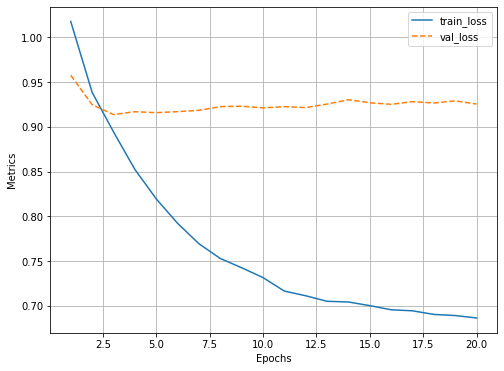

In [21]:
log.plot_epochs(['train_loss', 'val_loss']) 

100%|████████████████████████████████████████| 121/121 [00:00<00:00, 164.54it/s]


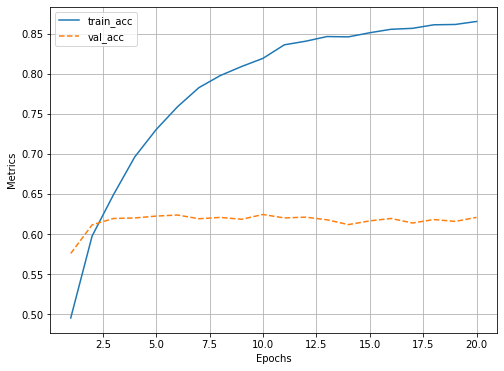

In [22]:
log.plot_epochs(['train_acc', 'val_acc'])

## - F1 Score & Confusion Matrix

In [23]:
def plot_confusion_matrix(y_true, y_pred, class_list,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_list))
    cm = confmat(torch.tensor(y_pred), torch.tensor(y_true)).cpu().numpy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_list, yticklabels=class_list,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [24]:
len(total_label), len(total_predict)

(3001, 3001)

In [25]:
# F1 score
f1 = F1Score(num_classes=len(class_list))
print('F1 scores:', f1(torch.tensor(total_label), torch.tensor(total_predict)))

F1 scores: tensor(0.6198)


Confusion matrix, without normalization
[[646 144 267]
 [313 319  79]
 [291  47 895]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

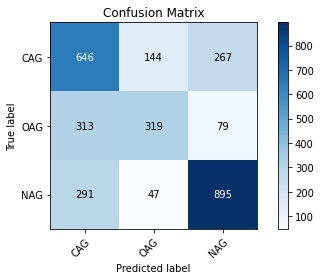

In [26]:
# Confusion Matrix
plot_confusion_matrix(np.array(total_label), np.array(total_predict), class_list=class_list, normalize=False,
                      title='Confusion Matrix')